In [1]:
# setup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.integrate

In [9]:
# setup: has to be in a separate cell for some reason
plt.rcParams['figure.figsize'] = [12, 7]

# A Lotka-Volterra-ish model

Suppose we are modeling the population sizes
of two interacting species, 
wihch we creatively call "type `0`" and "type `1`".
The dynamics are:

1. Each time step, each type-0 individual has probability $p_0$ of dying;
   those who die leave behind a Poisson number of offspring.
2. The mean number of offspring depends on the current amount of resources:
   it is equal to $\lambda_0 \exp(- (N + a_0 M)/K_0)$ when there are $N$ and $M$ individuals of the two types, respectively.
3. Same, vice-versa.

*Note:* for simplicity, we've kept death and reproduction *coupled*,
which might seem wierd, but imagine annual plants.

How do we expect this to behave?
Let's write down the *expected* dynamics:
$$\begin{aligned}
  \mathbb{E}[N_{t+1} | N_t = N, M_t = M]
      &= N (1 - p_0) + p_0 N \lambda_0 \exp(- (N + a_0 M)/K_0) \\
  \mathbb{E}[M_{t+1} | N_t = N, M_t = M]
      &= M (1 - p_1) + p_1 M \lambda_1 \exp(- (M + a_1 N)/K_1) .
\end{aligned}$$

### The differential equations

The amount that $N$ changes per unit time is $N_{t+1} - N_t$.
This suggests the following differential equation:
$$\begin{aligned}
  \frac{dN}{dt}
      &= p_0 N_t \left(\lambda_0 \exp\left( - \frac{N_t + a_0 M_t}{K_0} \right) - 1\right) \\
  \frac{dM}{dt}
      &= p_1 M_t \left(\lambda_1 \exp\left( - \frac{M_t + a_1 N_t}{K_1} \right) - 1 \right)
\end{aligned}$$

We'll be using these again,
so we'll denote this by $F : \mathbb{R}^2 \mapsto \mathbb{R}^2$:
$$\begin{aligned}
    F(N, M) &= \big( p_0 N \left(\lambda_0 \exp(- (N + a_0 M)/K_0) - 1\right), \\
            & \qquad p_1 M \left(\lambda_1 \exp(- (M + a_1 N)/K_1) - 1\right) \big) .
\end{aligned}$$

In [3]:
def run_sim_2d(N0, M0, gen_fn, ngens, dtype='int', **kwargs):
    """
    N0, M0: initial population size arrays for the two populations
    gen_fn: function that calculates the next generation of population sizes
        given the current population sizes. Takes in two arrays and other arguments
        and outputs a tuple of length two of the next generation's population sizes.
    ngens: number of generations to do this for
    dtype: the numpy type (eg either 'int' or 'float') that gen_fn returns
    **kwargs : the other parameters for gen_fn
    
    returns: a tuple of arrays, each of size (ngens, len(N0)),
        with columns corresponding to replicates and rows corresponding to time points
    """
    assert(len(N0) == len(M0))
    N = np.empty((ngens, len(N0)), dtype=dtype)
    N[0, :] = N0
    M = np.empty((ngens, len(M0)), dtype=dtype)
    M[0, :] = M0
    for t in range(1, ngens):
        n, m = gen_fn(N[t-1, :], M[t-1, :], **kwargs)
        assert(n.dtype == dtype and m.dtype == dtype)
        N[t, :], M[t, :] = n, m
    return N, M


## Simulations

Here's what this looks like:

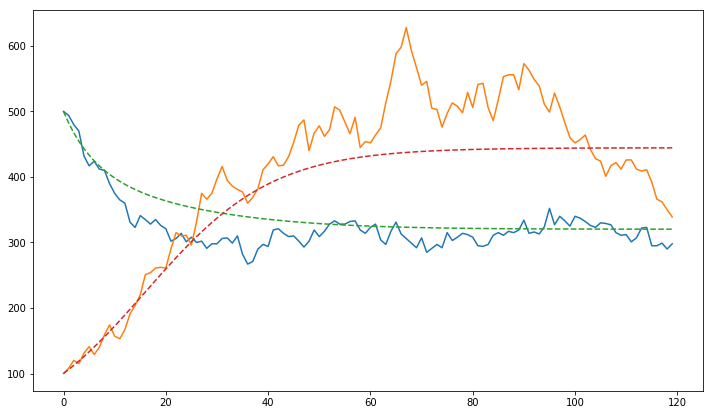

In [10]:
def lv_eqn(N, M, lam, p, K, a):
    next_N = N + p[0] * N * (lam[0] * np.exp(-(N + a[0] * M)/K[0]) - 1)
    next_M = M + p[1] * M * (lam[1] * np.exp(-(M + a[1] * N)/K[1]) - 1)
    return next_N, next_M

def lv_gen(N, M, lam, p, K, a):
    assert(len(M) == len(N))
    N_dies = np.random.binomial(N, p[0])
    M_dies = np.random.binomial(M, p[1])
    N_repro = np.random.poisson(N_dies * lam[0] * np.exp(-((N + a[0]*M)/K[0])))
    M_repro = np.random.poisson(M_dies * lam[1] * np.exp(-((M + a[1]*N)/K[1])))
    next_N = N - N_dies + N_repro
    next_M = M - M_dies + M_repro
    return next_N, next_M

# we'll use **kwargs to avoid re-typing these over and over
lv_args = {
        'lam' : [1.2, 1.1],    # fecundity
        'p' : [0.5, 0.9],      # death prob
        'K' : [2000, 5000],      # carrying capacity
        'a' : [0.1, 0.1]  # encounter rate
    }

# random simulation
N, M = run_sim_2d([500], [100], lv_gen, 120, dtype='int',
                    **lv_args)
# deterministic
tN, tM = run_sim_2d([500], [100], lv_eqn, 120, dtype='float',
                    **lv_args)

fig, ax = plt.subplots()
ax.plot(np.column_stack([N, M]))
ax.plot(np.column_stack([tN, tM]), linestyle="--")


## Equilibrium

*Equilibria* occur when $F(N, M) = 0$.

First note that if $M=0$ then the model is one-dimensional,
and so there are equilibria on the boundary.
These occur when $\mathbb{E}[N_{t+1}] = N$,
which happens only if the average number of new offspring for a given parent is 1,
i.e., 
$$\begin{aligned}
 F(N_0, 0) = 0 \qquad \Rightarrow \qquad N_0 &= K_0 \log(\lambda_0) \\
 F(0, M_0) = 0 \qquad \Rightarrow \qquad M_0 &= K_1 \log(\lambda_1) .
\end{aligned}$$

For an *internal* equilibrium,
i.e., one where both co-exists,
we require that
$\lambda_0 \exp(- (N + a_0 M)/K_0) = 1$,
and this happens only if
$(N + a_0 M)/K_0 = \log \lambda_0$.

Writing out the equations for both species,
equilibrium occurs when
$$\begin{aligned}
  N + a_0 M &= K_0 \log(\lambda_0) \\
  a_1 N + M &= K_1 \log(\lambda_1)  
\end{aligned}$$
which is solved by
$$\begin{aligned}
  N_* &= \frac{K_0 \log(\lambda_0) - a_0 K_1 \log(\lambda_1)}{1 - a_0 a_1} \\
  M_* &= \frac{K_1 \log(\lambda_1) - a_1 K_0 \log(\lambda_0)}{1 - a_0 a_1} .
\end{aligned}$$

These only make sense if they are positive... but let's have a look at the pictures, first.

In [11]:
def lv_equil(lam, p, K, a):
    bequil = np.array([[K[0] * np.log(lam[0]), 0],
                       [0, K[1] * np.log(lam[1])]])
    equil = np.array([K[0] * np.log(lam[0]) - a[0] * K[1] * np.log(lam[1]),
                         K[1] * np.log(lam[1]) - a[1] * K[0] * np.log(lam[0])]) / (1 - a[0] * a[1])
    return np.row_stack([equil, bequil])

In [12]:
def phase_plot(genfn, xlim, ylim, nx, ny, scale=1, figax=None, **kwargs):
    xstep = int((xlim[1] - xlim[0]) / nx)
    ystep = int((ylim[1] - ylim[0]) / ny)
    X, Y = np.meshgrid(range(xlim[0], xlim[1], xstep), range(ylim[0], ylim[1], ystep))
    X.shape = Y.shape = (np.prod(X.shape),)
    U, V = genfn(X, Y, **kwargs)
    if figax is None:
        figax = plt.subplots()
    fig, ax = figax
    ax.quiver(X, Y, U-X, V-Y, angles='xy', scale_units='xy', scale=scale)
    return fig, ax

In [13]:
def do_plot(lv_args, init = [[500], [100]], nsteps=120, figax=None):  
    equil = lv_equil(**lv_args)

    tN, tM = run_sim_2d(init[0], init[1], lv_eqn, nsteps, dtype='float',
                        **lv_args)

    fig, ax= phase_plot(lv_eqn, xlim=[0, 600], ylim=[0, 600], nx=20, ny=20,
                           figax=figax, **lv_args)
    ax.plot(tN, tM)
    ax.scatter(tN, tM)
    ax.scatter(equil[0,0], equil[0,1], s=1000, c='g', alpha=0.5)
    ax.scatter(equil[1:,0], equil[1:,1], s=1000, c='r', alpha=0.5)
    ax.axis('equal')
    ax.set_xlabel("N")
    ax.set_ylabel("M")
    ax.set_aspect(1.0)
    return fig, ax

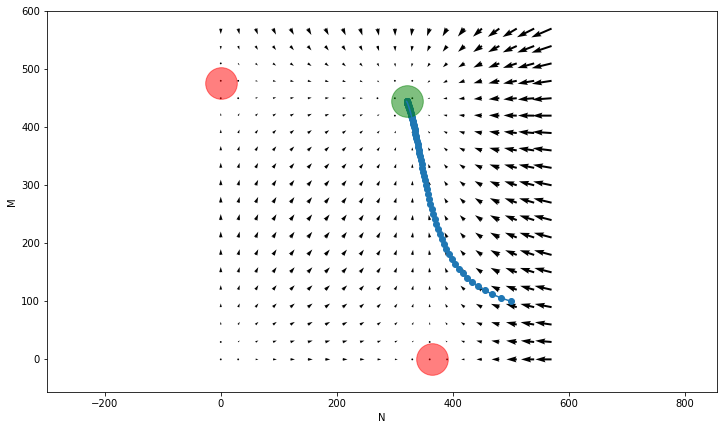

In [14]:
lv_args = {
        'lam' : [1.2, 1.1],    # fecundity
        'p' : [0.5, 0.9],      # death prob
        'K' : [2000, 5000],      # carrying capacity
        'a' : [0.1, 0.1]  # encounter rate
    }

fig, ax = do_plot(lv_args)

And, here is a stochastic simulation trajectory.
(Run again to add more.)

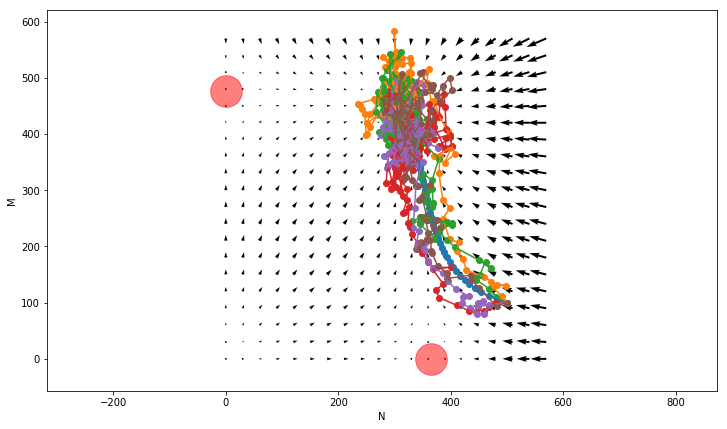

In [19]:
# random simulation
N, M = run_sim_2d([500], [100], lv_gen, 120, dtype='int', **lv_args)
ax.plot(N, M)
ax.scatter(N, M)
fig

## Isoclines

A nice way to look at phase plots
is to draw on them the *isoclines*,
i.e., the lines along which each variable does not change.
We saw above that $N$ does not change if
$$\begin{aligned}
  N + a_0 M &= K_0 \log(\lambda_0),
\end{aligned}$$
and $M$ does not change if
$$\begin{aligned}
  a_1 N + M &= K_1 \log(\lambda_1) . 
\end{aligned}$$
These are just *straight lines* in phase space.

In [20]:
def plot_isoclines(ax, lam, p, K, a, Nmax=600):
    xx = np.array([0.0, Nmax])
    ax.plot(K[0] * np.log(lam[0]) - xx * a[0], xx)
    ax.plot(xx, K[1] * np.log(lam[1]) - xx * a[1])

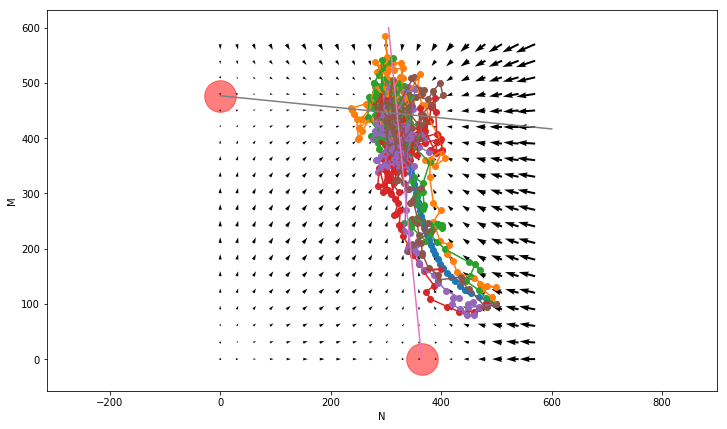

In [21]:
plot_isoclines(ax, **lv_args)
fig

## No equilibrium?

**But:** here's a different set of parameters:

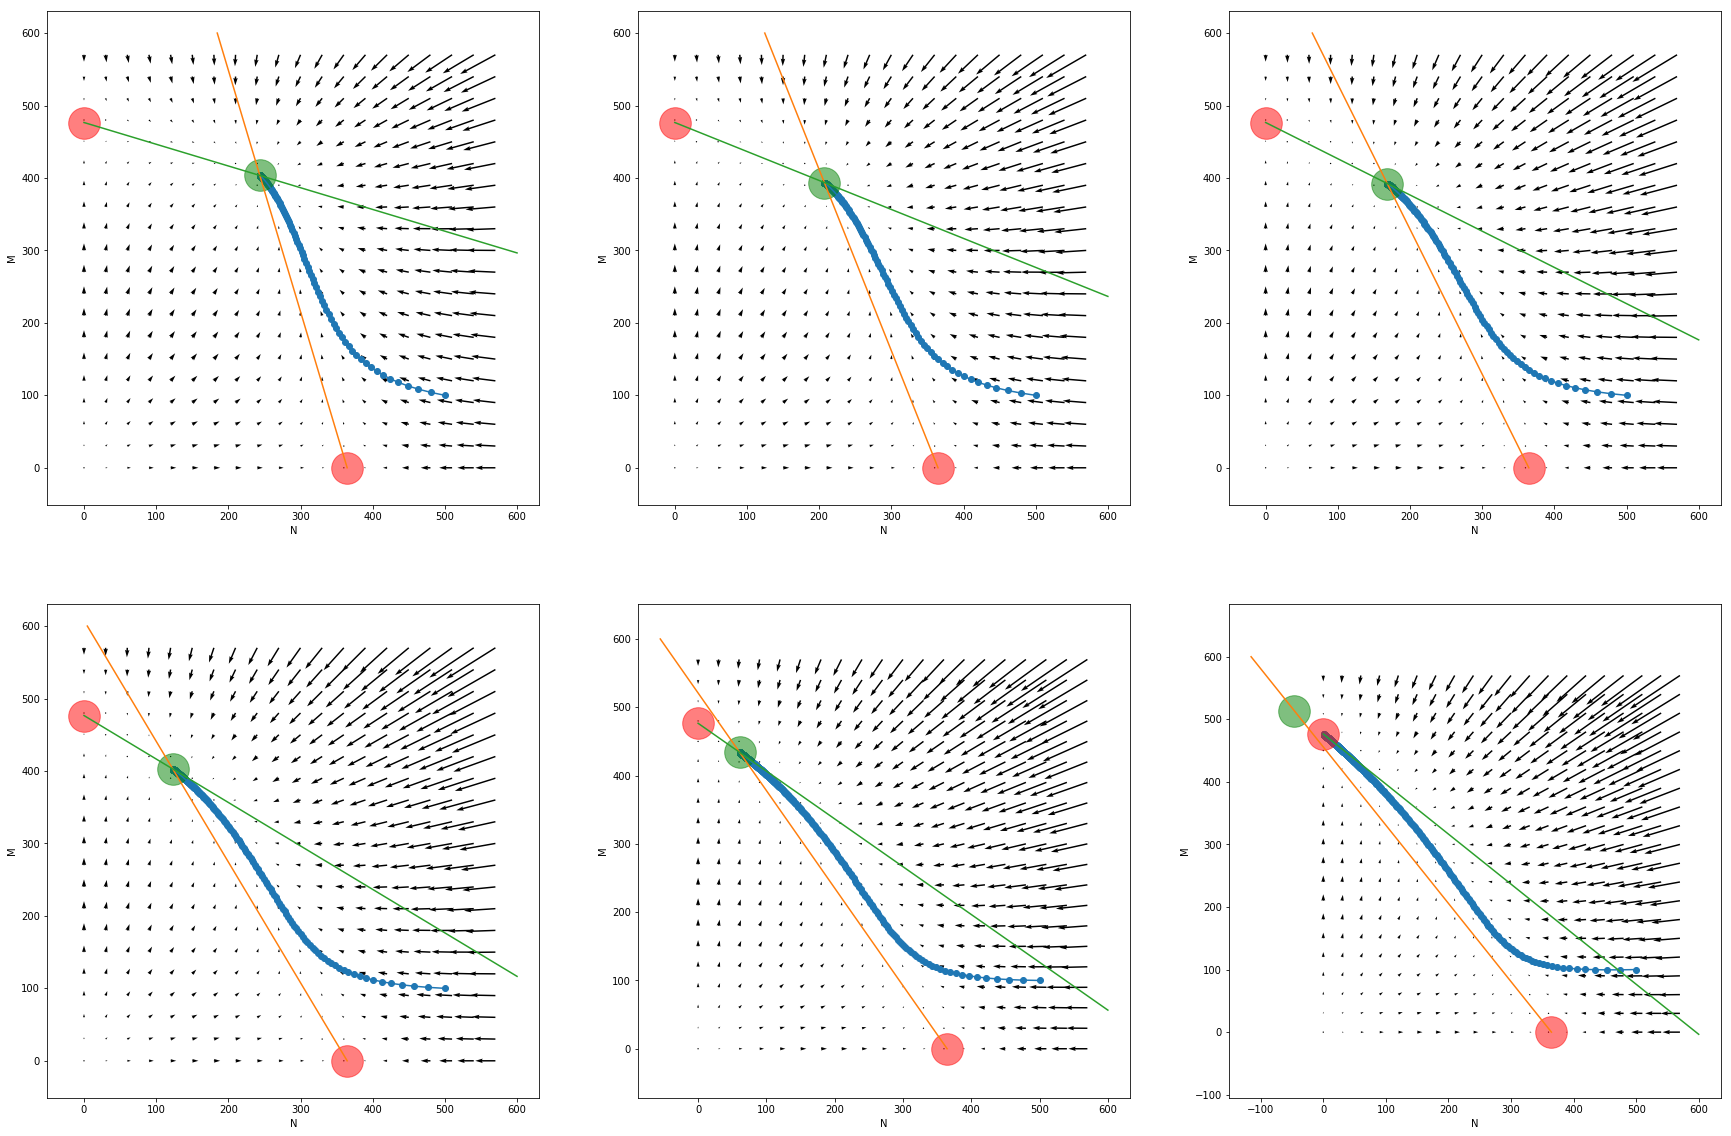

In [22]:
lv_args = {
        'lam' : [1.2, 1.1],    # fecundity
        'p' : [0.5, 0.9],      # death prob
        'K' : [2000, 5000],      # carrying capacity
        'a' : [0.75, 0.75]  # encounter rate
    }

plt.rcParams['figure.figsize'] = [30, 20]
fig, axes = plt.subplots(2, 3)
for a, ax in zip([0.3, 0.4, 0.5, 0.6, 0.7, 0.8], axes.flatten()):
    lv_args['a'] = [a, a]
    fig, ax = do_plot(lv_args, figax=(fig, ax), nsteps=1000)
    plot_isoclines(ax, **lv_args)

### Stability of equilibria

Recall the internal equilibrium of this system is
$$\begin{aligned}
  N_* &= \frac{K_0 \log(\lambda_0) - a_0 K_1 \log(\lambda_1)}{1 - a_0 a_1} \\
  M_* &= \frac{K_1 \log(\lambda_1) - a_1 K_0 \log(\lambda_0)}{1 - a_0 a_1} .
\end{aligned}$$

In the case that $a_0 a_1 < 1$, these are positive iff
$$\begin{aligned}
  \frac{1}{a_1} K_1 \log(\lambda_1) > K_0 \log(\lambda_0) &> a_0 K_1 \log(\lambda_1)
\end{aligned}$$

What happens if they are not positive? Since growth without bound is not possible,
the dynamics approach a boundary.
But, which one? What we need to know is whether the trajectories started *a little away*
from the equilbria tend to get closer or farther away.
For instance, if $F_M(N_0, \epsilon) > 0$,
then even small numbers of the second species will grow when the first species is at its boundary equilibrium.

To find out, we look at the gradient of $F$, which we denote $H$:
$$\begin{aligned}
    H_{NN} &= \frac{d}{dN} F_N(N, M) \\
           &= p_0 \left\{ \left(1 - \frac{N}{K_0}\right) \lambda_0 \exp(- (N + a_0 M)/K_0) - 1 \right\}, \\
    H_{NM} &= \frac{d}{dN} F_M(N, M) \\
           &= - p_0 a_0 \frac{N}{K_0} \lambda_0 \exp(- (N + a_0 M)/K_0), \\
    H_{MN} &= \frac{d}{dN} F_M(N, M) \\
           &= - p_1 a_1 \frac{M}{K_1} \lambda_1 \exp(- (M + a_1 N)/K_1), \\
    H_{MM} &= \frac{d}{dM} F_M(N, M) \\
           &= p_1 \left\{ \left(1 - \frac{M}{K_1}\right) \lambda_1 \exp(- (M + a_1 N)/K_1) - 1 \right\} .
\end{aligned}$$

So - $F_M(N_0, \epsilon) \approx \epsilon H_{MM}(N_0, 0)$,
and since $N_0 = K_0 \log \lambda_0$,
$$\begin{aligned}
H_{MM}(N_0, 0)
      &= p_1 \left\{ \lambda_1 \exp(- a_1 \log(\lambda_0) K_0/K_1) - 1 \right\} \\
      &= p_1 \left\{ \lambda_1 \lambda_0^{- a_1 K_0/K_1} - 1 \right\} .
\end{aligned}$$
In other words, the second species, $M$, can *invade* the equilibrium of the first, $N$,
if
$$
   K_1 \log(\lambda_1) > a_1 K_0 \log(\lambda_0) .
$$

In [23]:
def lv_H(lam, p, K, a):
    def H(N, M):
        HNN = p[0] * ( (1 - N/K[0]) * lam[0] * np.exp(- (N + a[0] * M)/ K[0]) - 1)
        HNM = - p[0] * a[0] * N / K[0] * lam[0] * np.exp(- (N + a[0] * M)/ K[0])
        HMN = - p[1] * a[1] * M / K[1] * lam[1] * np.exp(- (M + a[1] * N)/ K[1])
        HMM = p[1] * ( (1 - M/K[1]) * lam[1] * np.exp(- (M + a[1] * N)/ K[1]) - 1)
        return np.array([[HNN, HNM], [HMN, HMM]])
    return H

H = lv_H(**lv_args)
for eq in lv_equil(**lv_args):
    print("Equilibrium:", eq)
    print("   with H = \n", H(*eq))

Equilibrium: [-46.10446008 513.43446709]
   with H = 
 [[ 0.01152612  0.00922089]
 [-0.07393456 -0.0924182 ]]
Equilibrium: [364.64311359   0.        ]
   with H = 
 [[-0.09116078 -0.07292862]
 [-0.          0.03389316]]
Equilibrium: [  0.         476.55089902]
   with H = 
 [[-0.00413223 -0.        ]
 [-0.06862333 -0.08577916]]
